In [79]:
import numpy as np
import control as ctrl
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

In [80]:
Ts = 0.01

A = np.array([[1]])
B = np.array([[1]])
C = np.array([[1]])
D = np.array([0])

sys_c = ctrl.ss(A, B, C, D)
sys_d = ctrl.c2d(sys_c, Ts, method='zoh')
Ad = sys_d.A
Bd = sys_d.B
Cd = sys_d.C
Dd = sys_d.D

print("Discrete-time system matrices:")
print("Ad:", Ad)
print("Bd:", Bd)
print("Cd:", Cd)
print("Dd:", Dd)

Discrete-time system matrices:
Ad: [[1.01005017]]
Bd: [[0.01005017]]
Cd: [[1.]]
Dd: [[0.]]


In [81]:
np.random.seed(42)  

scale_factor = 1000

state1_x0 = np.round(np.random.uniform(-0.1, 0.1) * scale_factor).astype(np.int32)
state2_x0 = np.round(np.random.uniform(-0.1, 0.1) * scale_factor).astype(np.int32)
state3_x0 = np.round(np.random.uniform(-0.1, 0.1) * scale_factor).astype(np.int32)
state4_x0 = np.round(np.random.uniform(-0.1, 0.1) * scale_factor).astype(np.int32)
state5_x0 = np.round(np.random.uniform(-0.1, 0.1) * scale_factor).astype(np.int32)
state6_x0 = np.round(np.random.uniform(-0.1, 0.1) * scale_factor).astype(np.int32)
state7_x0 = np.round(np.random.uniform(-0.1, 0.1) * scale_factor).astype(np.int32)
state8_x0 = np.round(np.random.uniform(-0.1, 0.1) * scale_factor).astype(np.int32)
state9_x0 = np.round(np.random.uniform(-0.1, 0.1) * scale_factor).astype(np.int32)

state1_z0 = np.round(np.random.uniform(-0.01, 0.01) * scale_factor).astype(np.int32)
state2_z0 = np.round(np.random.uniform(-0.01, 0.01) * scale_factor).astype(np.int32)
state3_z0 = np.round(np.random.uniform(-0.01, 0.01) * scale_factor).astype(np.int32)
state4_z0 = np.round(np.random.uniform(-0.01, 0.01) * scale_factor).astype(np.int32)
state5_z0 = np.round(np.random.uniform(-0.01, 0.01) * scale_factor).astype(np.int32)
state6_z0 = np.round(np.random.uniform(-0.01, 0.01) * scale_factor).astype(np.int32)
state7_z0 = np.round(np.random.uniform(-0.01, 0.01) * scale_factor).astype(np.int32)
state8_z0 = np.round(np.random.uniform(-0.01, 0.01) * scale_factor).astype(np.int32)
state9_z0 = np.round(np.random.uniform(-0.01, 0.01) * scale_factor).astype(np.int32)

NODES = {
    0: {'x0': state1_x0, 'z0': state1_z0, 'neighbors': [3]},
    1: {'x0': state2_x0, 'z0': state2_z0, 'neighbors': [4]},
    2: {'x0': state3_x0, 'z0': state3_z0, 'neighbors': [7]},
    3: {'x0': state4_x0, 'z0': state4_z0, 'neighbors': [6]},
    4: {'x0': state5_x0, 'z0': state5_z0, 'neighbors': [8]},
    5: {'x0': state6_x0, 'z0': state6_z0, 'neighbors': [1]},
    6: {'x0': state7_x0, 'z0': state7_z0, 'neighbors': [2]},
    7: {'x0': state8_x0, 'z0': state8_z0, 'neighbors': [5]},
    8: {'x0': state9_x0, 'z0': state9_z0, 'neighbors': [0]},
}

In [82]:
dt = 0.01
n_points = 2000
n_agents = len(NODES)  
mv = np.zeros(shape=(n_agents, n_points))

eta = 0.5
epsilon = 0.01 # freeze threshold
small_error_timer = np.zeros(n_agents)
freeze_time = 1.0
freeze_steps = int(freeze_time / dt)

# Graph (Laplacian for a ring network)
L = np.zeros((n_agents, n_agents))
for i in range(n_agents):
    L[i, i] = 2
    L[i, (i + 1) % n_agents] = -1
    L[i, (i - 1) % n_agents] = -1

def v_i(i, z, neighbors):
    vi = 0.0
    for j in neighbors:
        vi += (-1) * np.sign(z[i] - z[j]) * np.sqrt(np.abs(z[i] - z[j]))
    return vi

def g_i(i, z, neighbors, avg=False):
    if avg:
        if not neighbors:
            return 0.0
        return sum(z[j] - z[i] for j in neighbors)
    else:
        vi = v_i(i, z, neighbors)
        return vi

In [83]:
def dynamics(t, y, dydt_aux, n_agents, eta): 

    x = y[:n_agents]
    z = y[n_agents:]
    vartheta = y[2 * n_agents:3 * n_agents]

    for i in range(n_agents): 
        neighbors = NODES[i]['neighbors']

        gi = g_i(i, z, neighbors)
        z_dot = gi 

        sigma = x[i] - z[i]

        if i == 0: 
            print(f"Error for agent {i}: {sigma}, neighbors: {neighbors}, gi: {gi}")
            
        grad = np.sign(sigma)

        if np.abs(sigma) > epsilon:
            small_error_timer[i] = 0
            dtheta = eta * 1.0 
        else: 
            small_error_timer[i] += 1
            if small_error_timer[i] < freeze_steps:
                dtheta = eta * 1.0
            else:
                dtheta = 0.0

        vartheta_dot = dtheta 

        u = gi - vartheta[i] * grad
        x_dot = u 

        if int(t / dt) < n_points:
            mv[i, int(t / dt)] = u
        
        dydt_aux[i] = x_dot
        dydt_aux[n_agents + i] = z_dot
        dydt_aux[2 * n_agents + i] = vartheta_dot
    
    return dydt_aux

In [84]:
x = np.zeros(shape=(n_agents, n_points))
x0 = np.array([NODES[i]['x0'] for i in range(n_agents)])
z = np.zeros(shape=(n_agents, n_points))
z0 = np.array([NODES[i]['z0'] for i in range(n_agents)])
vartheta = np.zeros(shape=(n_agents, n_points))
vartheta0 = np.zeros(n_agents)

dydt = np.zeros(3 * n_agents)
y0 = np.concatenate([x0, z0, vartheta0])

time = 0.0
for k in range(n_points): 
    x[:, k] = x0
    z[:, k] = z0
    vartheta[:, k] = vartheta0

    # Update for next iteration
    t_span = np.linspace(time, time+Ts, 2)
    t_eval = np.linspace(time, time+Ts, 2)
    sol = solve_ivp(dynamics, t_span, y0, method='RK45', t_eval=t_eval, args=(dydt, n_agents, eta))
    y0 = sol.y[:, -1]  

    x0 = y0[:n_agents]
    z0 = y0[n_agents:2*n_agents]
    vartheta0 = y0[2*n_agents:3*n_agents]

    time += Ts

Error for agent 0: -29.0, neighbors: [3], gi: 1.7320508075688772
Error for agent 0: -29.0, neighbors: [3], gi: 1.7320253976794164
Error for agent 0: -28.999999997280508, neighbors: [3], gi: 1.731542542980722
Error for agent 0: -28.999999937791586, neighbors: [3], gi: 1.731288441295786
Error for agent 0: -28.999999551585724, neighbors: [3], gi: 1.730017505230088
Error for agent 0: -28.999999422668218, neighbors: [3], gi: 1.729791552925914
Error for agent 0: -28.99999928142447, neighbors: [3], gi: 1.729509041637057
Error for agent 0: -28.99999931888725, neighbors: [3], gi: 1.729508986053911
Error for agent 0: -28.9999979417479, neighbors: [3], gi: 1.7269318649904828
Error for agent 0: -28.999995684079536, neighbors: [3], gi: 1.725644207484114
Error for agent 0: -28.99998265229474, neighbors: [3], gi: 1.7191940575202973
Error for agent 0: -28.99997942291593, neighbors: [3], gi: 1.7180461759179595
Error for agent 0: -28.99997499876065, neighbors: [3], gi: 1.716610864827948
Error for agent 

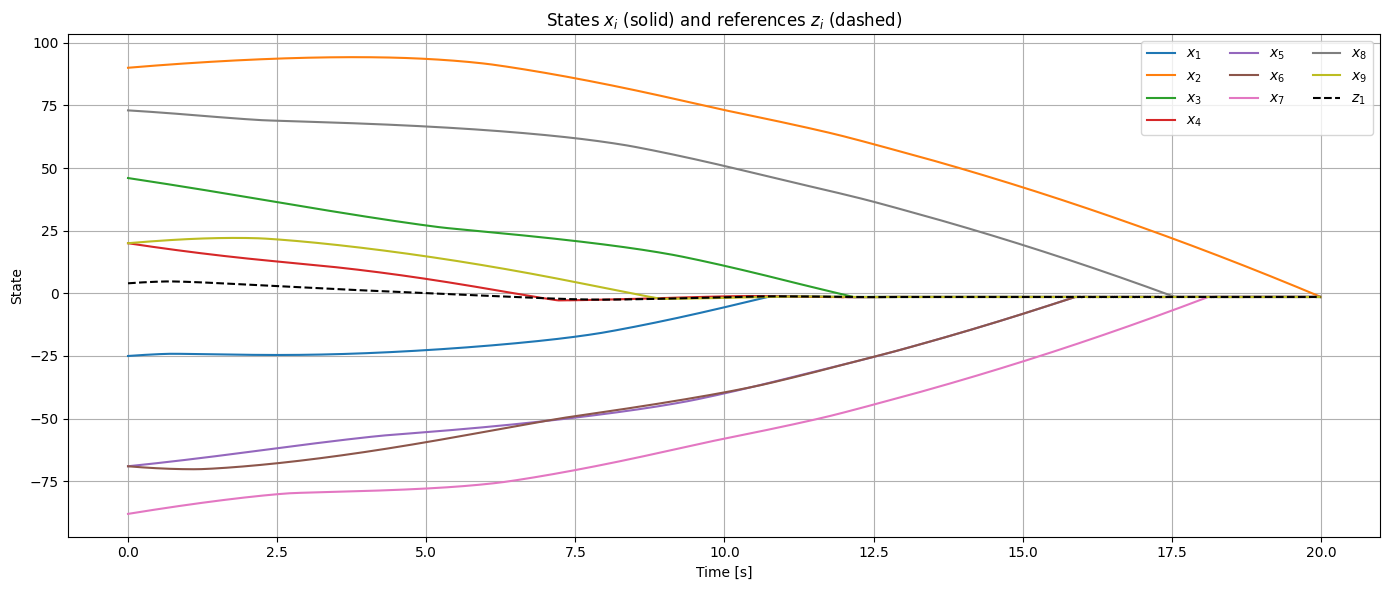

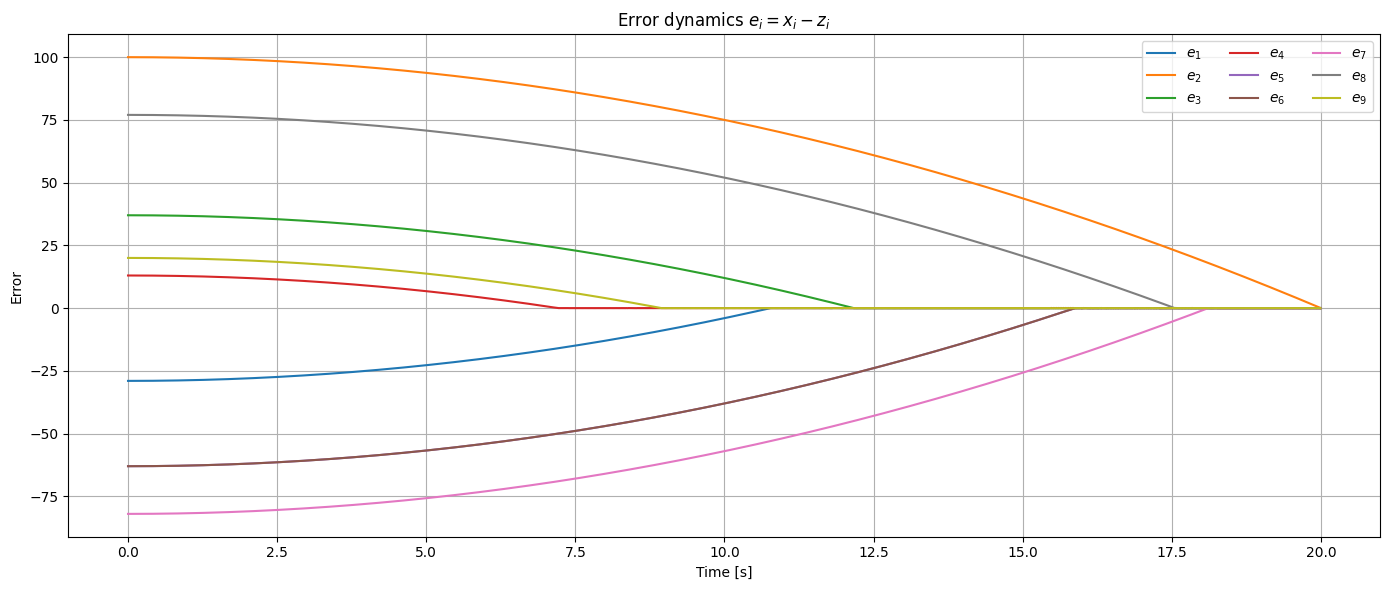

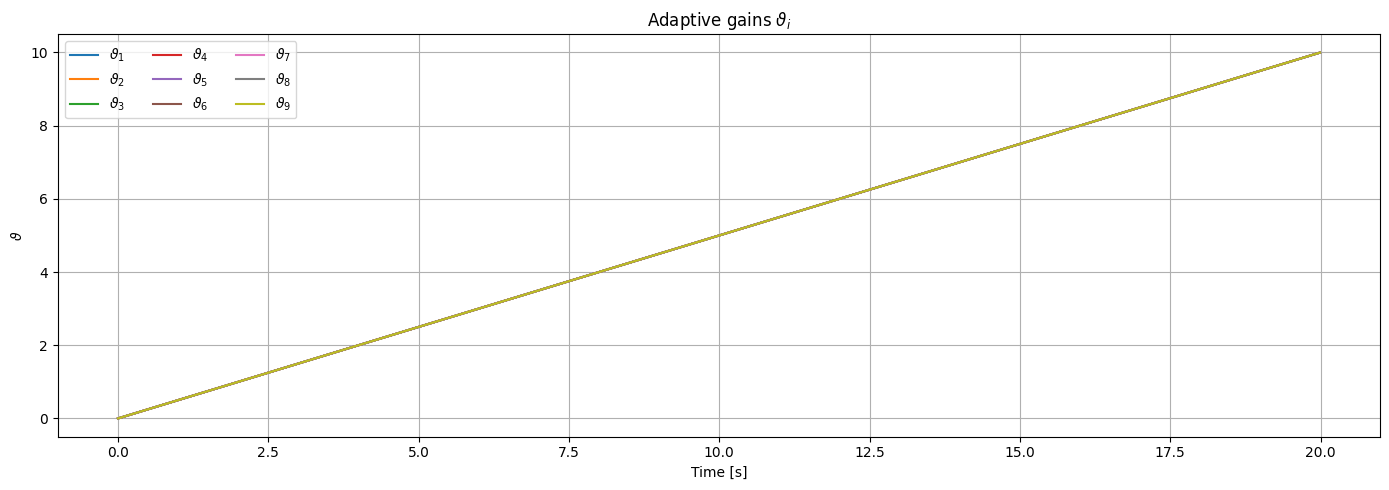

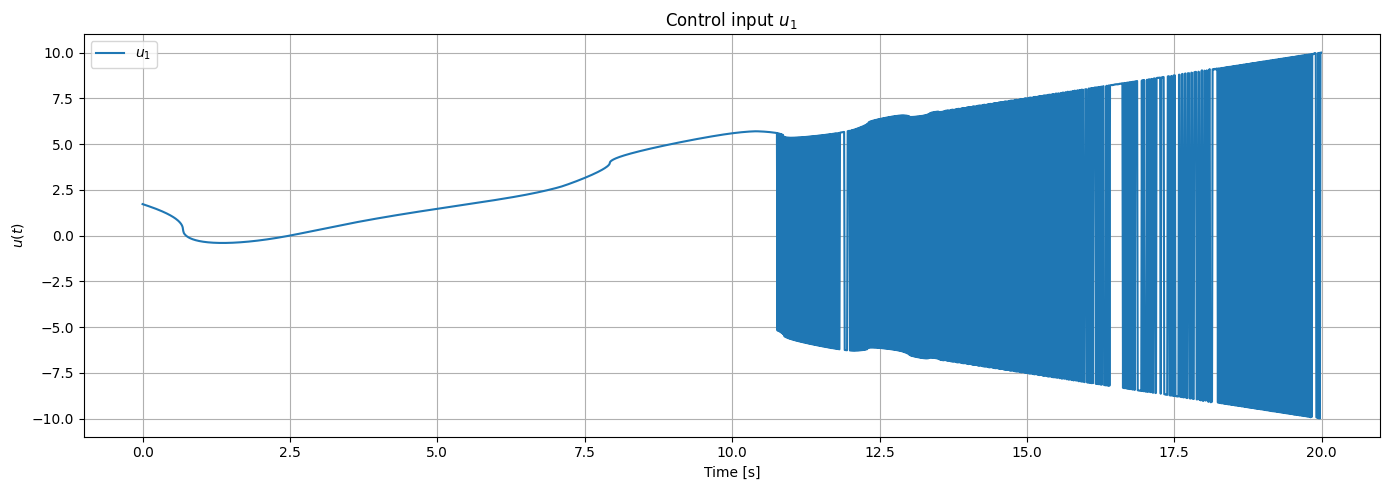

In [85]:
NUM_SIM = 1
SAVE_FIGS = False

t = np.linspace(0, dt* (n_points - 1), n_points)

plt.figure(figsize=(14, 6))
for i in range(n_agents):
    plt.plot(t, x[i,:], label=f'$x_{i+1}$')
plt.plot(t, z[0,:], 'k--', label=r'$z_{1}$')
plt.title('States $x_i$ (solid) and references $z_i$ (dashed)')
plt.xlabel('Time [s]')
plt.ylabel('State')
plt.legend(ncol=3)
plt.grid()
plt.tight_layout()
if SAVE_FIGS:
    plt.savefig(f'img/python-sim/state_evolution_{NUM_SIM}.pdf')

# === Plot: Error dynamics ===
plt.figure(figsize=(14, 6))
for i in range(n_agents):
    plt.plot(t, x[i,:] - z[i,:], label=f'$e_{i+1}$')
plt.title('Error dynamics $e_i = x_i - z_i$')
plt.xlabel('Time [s]')
plt.ylabel('Error')
#plt.ylim(-0.001, 0.001)
plt.legend(ncol=3)
plt.grid()
plt.tight_layout()
if SAVE_FIGS:
    plt.savefig(f'img/python-sim/error_dynamics_{NUM_SIM}.pdf')

# === Plot: adaptive gains ===
plt.figure(figsize=(14, 5))
for i in range(n_agents):
    plt.plot(t, vartheta[i,:], label=f'$\\vartheta_{i+1}$')
plt.title('Adaptive gains $\\vartheta_i$')
plt.xlabel('Time [s]')
plt.ylabel('$\\vartheta$')
plt.legend(ncol=3)
plt.grid()
plt.tight_layout()
if SAVE_FIGS:
    plt.savefig(f'img/python-sim/adaptive_gains_{NUM_SIM}.pdf')

plt.figure(figsize=(14, 5))
plt.plot(t, mv[0,:], label=f'$u_{1}$')
plt.title('Control input $u_1$')
plt.xlabel('Time [s]')
plt.ylabel('$u(t)$')
plt.legend(ncol=3)
plt.grid()
plt.tight_layout()
if SAVE_FIGS:
    plt.savefig(f'img/python-sim/control_input_{NUM_SIM}.pdf')

plt.show()

### **Euler Method**

**Laplacian for a 9-node ring network**
$$v = -\mathbf{L} z$$
$$g(z,v) = v$$
$$\dot{z} = g(z,v)$$

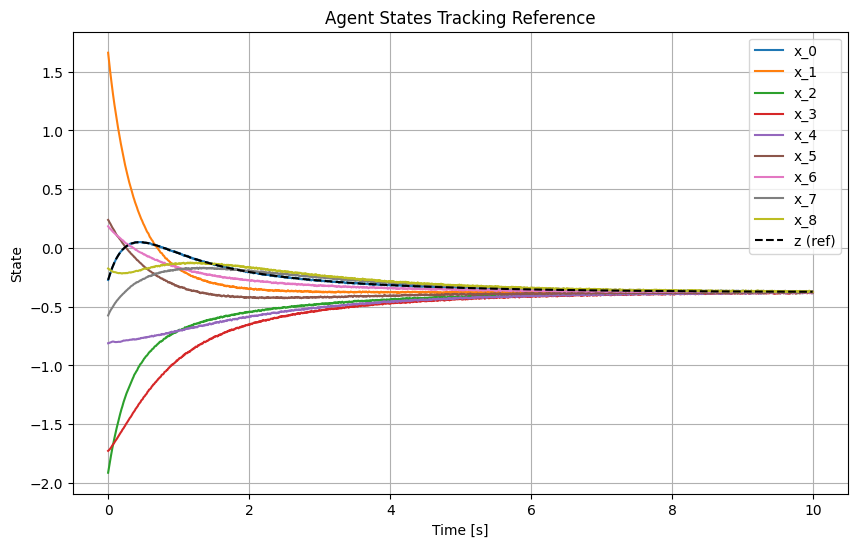

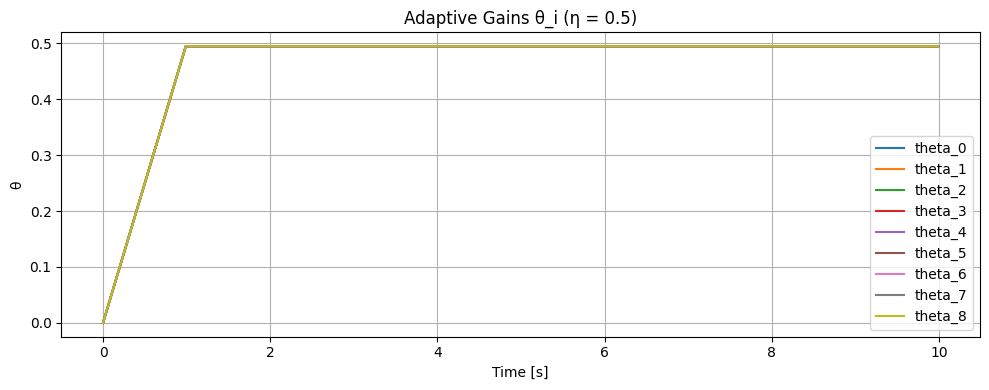

In [86]:
# Simulation parameters
T = 10.0
dt = 0.01
time = np.arange(0, T, dt)
n_agents = len(NODES) 

# Adaptive gain parameters
eta = 0.5  
small_error_timer = np.zeros(n_agents)
freeze_threshold = 0.01  # error threshold
freeze_time = 1.0        # seconds of small error before freezing
freeze_steps = int(freeze_time / dt)

# Graph (Laplacian for a ring network)
L = np.zeros((n_agents, n_agents))
for i in range(n_agents):
    L[i, i] = 2
    L[i, (i + 1) % n_agents] = -1
    L[i, (i - 1) % n_agents] = -1

# Initialization
x = np.random.uniform(-2, 2, (n_agents, len(time)))  # states
z = np.copy(x)                                       # reference
theta = np.zeros((n_agents, len(time)))              # adaptive gain
sigma = np.zeros((n_agents, len(time)))              # tracking error

# Disturbance
nu = 0.5 * (np.random.rand(n_agents, len(time)) - 0.5)  # bounded unknown input

# Adaptive control simulation
theta_max = 10.0
for k in range(len(time) - 1):
    # Reference dynamics
    v = -L @ z[:, k]
    g = v  # Assuming g_i(z_i, v_i) = v_i
    z[:, k + 1] = z[:, k] + dt * g

for k in range(len(time) - 1):
    # Reference dynamics
    v = -L @ z[:, k]
    g = v
    z[:, k + 1] = z[:, k] + dt * g

    # Compute sigma and gradient
    sigma[:, k] = x[:, k] - z[:, k]
    grad = np.sign(sigma[:, k])

    # Update adaptive gain theta with new eta parameter
    dtheta = np.zeros(n_agents)
    for i in range(n_agents):
        if np.abs(sigma[i, k]) > freeze_threshold:
            small_error_timer[i] = 0  # reset timer
            dtheta[i] = eta * 1.0  # NEW: multiplied by eta
        else:
            small_error_timer[i] += 1
            if small_error_timer[i] < freeze_steps:
                dtheta[i] = eta * 1.0  # NEW: multiplied by eta
            else:
                dtheta[i] = 0.0  # freeze gain

    theta[:, k + 1] = theta[:, k] + dt * dtheta
    theta[:, k + 1] = np.clip(theta[:, k + 1], 0, theta_max)

    # Control input
    u = g - theta[:, k] * grad
    x[:, k + 1] = x[:, k] + dt * (u + nu[:, k])

# Plotting results
plt.figure(figsize=(10, 6))
for i in range(n_agents):
    plt.plot(time, x[i], label=f"x_{i}")
plt.plot(time, z[0], 'k--', label="z (ref)")
plt.title("Agent States Tracking Reference")
plt.xlabel("Time [s]")
plt.ylabel("State")
plt.legend()
plt.grid()

plt.figure(figsize=(10, 4))
for i in range(n_agents):
    plt.plot(time, theta[i], label=f"theta_{i}")
plt.title("Adaptive Gains θ_i (η = {})".format(eta))  
plt.xlabel("Time [s]")
plt.ylabel("θ")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

$$\dot{z}_i = v_i = -\sum_{j\neq i}\text{sign}(z_i-z_j)|z_i-z_j|^{0.5}$$

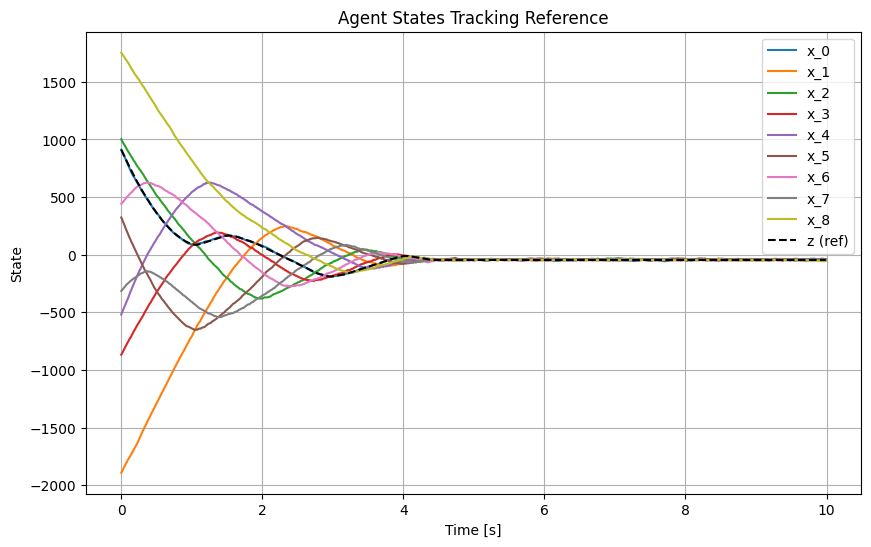

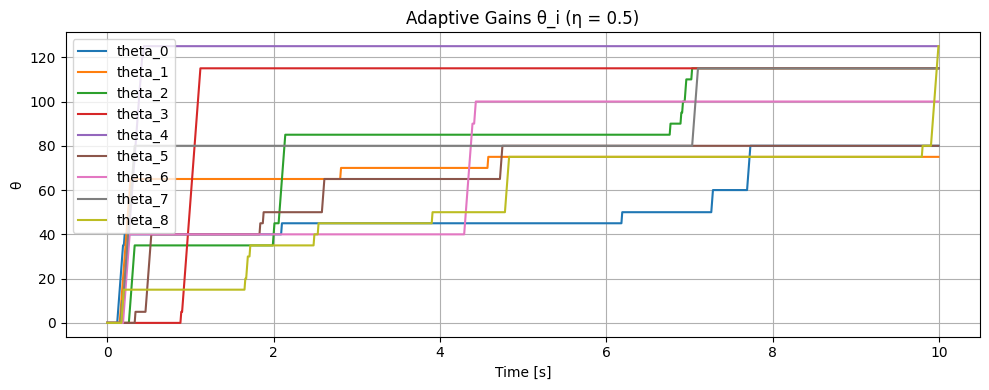

In [90]:
# Simulation parameters
T = 10.0
dt = 0.01
time = np.arange(0, T, dt)
n_agents = len(NODES) 

# Adaptive gain parameters
eta = 0.5  
small_error_timer = np.zeros(n_agents)
freeze_threshold = 0.01  # error threshold
freeze_time = 1.0        # seconds of small error before freezing
freeze_steps = int(freeze_time / dt)

# Initialization
x = np.random.uniform(-2, 2, (n_agents, len(time)))  # states
z = np.copy(x)                                           # reference
v = np.zeros((n_agents,))                                # reference dynamics
vtheta = np.zeros((n_agents, len(time)))                  # adaptive gain
sigma = np.zeros((n_agents, len(time)))                  # tracking error

# Disturbance
nu = 0.5 * (np.random.rand(n_agents, len(time)) - 0.5)  # bounded unknown input

# Initial floating-point values
x_f = np.random.uniform(-2, 2, n_agents)
z_f = np.copy(x_f)
vtheta_f = np.zeros(n_agents)

# Store initial values as int32
scale_factor = 1000  # scaling to preserve decimal precision when storing as int
x[:, 0] = np.round(x_f * scale_factor).astype(np.int32)
z[:, 0] = np.round(z_f * scale_factor).astype(np.int32)
vtheta[:, 0] = np.round(vtheta_f * scale_factor).astype(np.int32)

theta_max = 10.0
for k in range(len(time) - 1):

    z_f = z[:, k] / scale_factor  
    x_f = x[:, k] / scale_factor
    vtheta_f = vtheta[:, k] / scale_factor

    # Reference dynamics
    for i in range(n_agents):
        neighbors = NODES[i]['neighbors']
        v[i] = g_i(i, z_f, neighbors)

    g = v
    z_f_next = z_f + dt * g

    sigma[:, k] = x_f - z_f
    grad = np.sign(sigma[:, k])

     # Update adaptive gain theta
    dtheta = np.zeros(n_agents)
    for i in range(n_agents):
        if np.abs(sigma[i, k]) > freeze_threshold:
            small_error_timer[i] = 0
            dtheta[i] = eta* 1.0
        else:
            dtheta[i] = 0.0
            # if i == 0: 
            #     print(f"Agent {i} small error timer: {small_error_timer[i]}")

            # small_error_timer[i] += 1
            # if small_error_timer[i] < freeze_steps:
            #     dtheta[i] = eta * 1.0
            # else:
            #     dtheta[i] = 0.0

    vtheta_f_next = vtheta_f + dt * dtheta
    vtheta_f_next = np.clip(vtheta_f_next, 0, theta_max)

    # Control input
    u = g - vtheta_f * grad
    x_f_next = x_f + dt * (u + nu[:, k])

    # Store as int32
    z[:, k + 1] = np.round(z_f_next * scale_factor).astype(np.int32)
    x[:, k + 1] = np.round(x_f_next * scale_factor).astype(np.int32)
    vtheta[:, k + 1] = np.round(vtheta_f_next * scale_factor).astype(np.int32)


# Plotting results
plt.figure(figsize=(10, 6))
for i in range(n_agents):
    plt.plot(time, x[i], label=f"x_{i}")
plt.plot(time, z[0], 'k--', label="z (ref)")
plt.title("Agent States Tracking Reference")
plt.xlabel("Time [s]")
plt.ylabel("State")
plt.legend()
plt.grid()

plt.figure(figsize=(10, 4))
for i in range(n_agents):
    plt.plot(time, vtheta[i], label=f"theta_{i}")
plt.title("Adaptive Gains θ_i (η = {})".format(eta))  
plt.xlabel("Time [s]")
plt.ylabel("θ")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()